In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [3]:
drops = gpd.read_parquet('data/realFakeDrops.parquet')
drops

,dropID,vendor,tail_number,inc_name,inc_num,viirs_fireid,mtbs_eventID,false_pos,split_drop,IA_drop,AC_type,fluid,nonfire,knots,heading_true,alt_feet,gallons,geometry,latitude,longitude,line_length_mile,shape_length,drop_minute,drop_second,UTC_date_time,local_date,local_year,local_month,local_day,local_tz,local_hour,burn_severity,gm_pdsi,gm_srad,gm_vpd,aw_mat,aw_mcmt,aw_mwmt,aw_td,dem,dem_slope,dem_aspect,dem_flow_acc,landfire_fvt,landfire_fbfm40,biomass_afg,biomass_pfg,ndvi,dm_tmax,dm_tmin,hillshade,prev_area,gallon_sum,prev_perimID,fut_perimID,ros_before,ros_after,ros_change,efficacy_mean,real_drop
0,T-01_2018_173_00:44:34,latitude,T-01,GRAHAM 0420 OD,2018-OR955S-000420,F7767,OR4453912142620180621,NO,NO,YES,LAT,,,157.0,95.0,3110.0,2912.0,"MULTILINESTRING ((-1989720.393 2663595.103, -1...",44.553985,-121.403362,0.255131,410.593758,44,34,2018-06-22 00:44:34,43272.0,2018.0,6.0,21.0,America/Los_Angeles,17.0,1.850000,-5.260001,322.700043,1.320000,9.399999,0.400000,19.899998,19.500000,881.650024,11.082952,171.945786,23.650000,2424.250000,130.050003,418.399994,665.900024,0.27543,17.633585,4.864350,203.900000,6.539376e+06,22958.0,F7767_1,F7767_2,188.125000,0.000000,-188.125000,slowed,True
1,T-01_2018_173_01:24:10,latitude,T-01,GRAHAM 0420 OD,2018-OR955S-000420,F7767,OR4453912142620180621,NO,NO,YES,LAT,,,160.0,70.0,3018.0,2912.0,"MULTILINESTRING ((-1988457.392 2663538.622, -1...",44.556490,-121.387805,0.256315,412.499112,24,10,2018-06-22 01:24:10,43272.0,2018.0,6.0,21.0,America/Los_Angeles,18.0,1.600000,-5.260000,322.700012,1.320000,9.500000,0.500000,20.000000,19.500000,857.000000,16.557856,190.126877,8.400000,2054.800049,144.199997,336.200012,619.599976,0.24820,17.907667,4.975000,223.200000,6.539376e+06,22958.0,F7767_1,F7767_2,290.833333,0.000000,-290.833333,slowed,True
2,T-01_2018_173_02:09:44,latitude,T-01,GRAHAM 0420 OD,2018-OR955S-000420,F7767,OR4453912142620180621,NO,NO,YES,LAT,,,162.0,42.0,2962.0,2933.0,"MULTILINESTRING ((-1987696.874 2663489.501, -1...",44.557867,-121.378387,0.257586,414.544619,09,44,2018-06-22 02:09:44,43272.0,2018.0,6.0,21.0,America/Los_Angeles,19.0,2.000000,-5.260001,322.700043,1.320000,9.500000,0.500000,20.000000,19.500000,820.099976,20.405041,163.503204,7.500000,2049.399902,125.250000,377.700012,592.599976,0.24820,17.062267,4.645667,226.350000,6.539376e+06,22958.0,F7767_1,F7767_2,368.333333,0.000000,-368.333333,slowed,True
3,T-01_2018_173_02:43:15,latitude,T-01,GRAHAM 0420 OD,2018-OR955S-000420,F7767,OR4453912142620180621,NO,NO,YES,LAT,,,145.0,68.0,2834.0,2885.0,"MULTILINESTRING ((-1987277.378 2663826.468, -1...",44.561778,-121.374403,0.290613,467.697509,43,15,2018-06-22 02:43:15,43272.0,2018.0,6.0,21.0,America/Los_Angeles,19.0,1.000000,-4.770000,320.600006,1.350000,9.500000,0.500000,20.000000,19.500000,757.000000,12.101923,161.385498,3.000000,2080.000000,122.000000,172.000000,606.000000,0.24820,17.036333,4.636000,212.000000,6.539376e+06,22958.0,F7767_1,F7767_2,427.045455,0.000000,-427.045455,slowed,True
4,T-01_2018_174_21:19:28,latitude,T-01,BOXCAR 0410 RN,2018-ORPRD-000410,F7768,OR4516012107120180621,NO,NO,NO,LAT,,,148.0,261.0,1282.0,2906.0,"MULTILINESTRING ((-1945648.834 2723113.575, -1...",45.173840,-121.062320,0.332562,535.208456,19,28,2018-06-23 21:19:28,43274.0,2018.0,6.0,23.0,America/Los_Angeles,14.0,2.250000,-4.040000,335.500000,1.480000,11.199999,1.200000,22.500000,21.300001,339.937500,15.591919,193.330643,3.218750,2154.000000,114.343750,719.312500,285.375000,0.24980,20.497416,6.278083,210.687500,2.061742e+08,29578.0,F7768_4,None,42.500000,0.000000,-42.500000,persistant,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1167,None,None,None,None,None,F12981,OR4417212223120200908,None,None,None,None,None,None,NaN,NaN,NaN,NaN,"LINESTRING (-2064359.847 2642539.84, -2064573....",NaN,NaN,0.138922,223.573277

In [4]:
realDrops = drops.loc[drops.real_drop]
fakeDrops = drops.loc[~drops.real_drop]

len(fakeDrops.viirs_fireid.unique()), len(realDrops.viirs_fireid.unique())

(31, 31)

In [5]:
predictColumns = [
    'line_length_mile','gm_pdsi','gm_srad',
    'gm_vpd','aw_mat','aw_mcmt','aw_mwmt','aw_td','dem','dem_slope',
    'dem_aspect','dem_flow_acc','landfire_fvt','landfire_fbfm40',
    'biomass_afg','biomass_pfg','ndvi','dm_tmax','dm_tmin',
    'prev_area','hillshade'
]


In [6]:
n = len(fakeDrops.viirs_fireid.unique())
numDrops = len(fakeDrops)
fakeValidIDs = np.random.choice(fakeDrops.viirs_fireid.unique(), size=n//3, replace=False)
fakeValidIDs = [
    'F12984', 'F12963', 'F14266','F11231', 'F9219', 'F15297', 'F17009', 'F11644', 'F11107', 'F7760',
]
fakeValidNum = len(fakeDrops.loc[fakeDrops.viirs_fireid.isin(fakeValidIDs)])
fakeValidNum/numDrops*100

31.91126279863481

In [7]:
validationDrops = drops.loc[drops.viirs_fireid.isin(fakeValidIDs)]
trainDrops = fakeDrops.loc[~fakeDrops.viirs_fireid.isin(fakeValidIDs)]
len(trainDrops)/len(fakeDrops)*100

68.08873720136519

In [8]:
x = drops[predictColumns]
y = drops.efficacy_mean
x_train = x.loc[trainDrops.index]
y_train = y.loc[trainDrops.index]
x_test = x.loc[validationDrops.index]
y_test = y.loc[validationDrops.index]
x_train.head()

,line_length_mile,gm_pdsi,gm_srad,gm_vpd,aw_mat,aw_mcmt,aw_mwmt,aw_td,dem,dem_slope,dem_aspect,dem_flow_acc,landfire_fvt,landfire_fbfm40,biomass_afg,biomass_pfg,ndvi,dm_tmax,dm_tmin,prev_area,hillshade
586,0.093955,-1.54,133.0,0.46,5.508333,-4.400001,17.208334,21.608335,1515.583374,6.557497,220.502457,9.666667,2072.500000,143.666672,33.166668,579.333313,0.3059,0.600968,-8.623549,1.052272e+06,194.916667
587,0.096471,-1.54,133.0,0.46,5.510000,-4.400001,17.210001,21.610001,1514.900024,6.501947,211.287308,318.200012,2072.699951,141.399994,29.100000,622.000000,0.3059,0.600968,-8.623549,1.052272e+06,195.800000
588,0.103953,-1.54,133.0,0.46,5.520000,-4.400001,17.219999,21.620001,1513.300049,6.569751,196.247131,627.099976,2072.699951,161.300003,26.299999,623.900024,0.3059,0.600968,-8.623549,1.052272e+06,197.300000
589,0.059512,-1.54,133.0,0.46,5.500000,-4.400000,17.199999,21.600000,1523.333374,5.151750,109.738304,498.500000,2041.000000,166.000000,5.000000,274.666656,0.3059,0.600968,-8.623549,1.052272e+06,183.000000
590,0.085011,-1.54,133.0,0.46,5.600000,-4.400000,17.299999,21.700001,1509.000000,7.286859,201.974182,2.000000,2106.000000,121.000000,58.000000,959.000000,0.3059,0.600968,-8.623549,1.052272e+06,200.000000


In [9]:
cat_features = []
num_features = [item for item in predictColumns if item not in cat_features]

In [10]:
cat_processor = Pipeline(steps=[
    ('encoder',OneHotEncoder(handle_unknown='ignore'))    
])
num_processor = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='mean')),
    ('scaler',StandardScaler())
])
feature_processor = ColumnTransformer(transformers=[
    ('num',num_processor,x.columns),
    ('cat',cat_processor,cat_features)
])
pipe = Pipeline(steps=[
    ('feature_processor',feature_processor),
    ('model',RandomForestClassifier(random_state=42))
])

In [11]:
parameters = {"model__class_weight" : ['balanced',None] ,
              "model__min_samples_leaf" : [1, 4, 8], 
              "model__min_samples_split" : [2, 8, 12], 
              "model__n_estimators" : [10, 100, 150], 
              "model__max_depth" : [2,10,None]
             }

grid = GridSearchCV(pipe, 
                    parameters,
                    scoring='balanced_accuracy',
                    n_jobs=-1,
                    verbose=True)
grid.fit(x_train, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


C:\Users\linds\mambaforge\envs\aerialFire\lib\site-packages\numpy\ma\core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(estimator=Pipeline(steps=[('feature_processor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['line_length_mile', 'gm_pdsi', 'gm_srad', 'gm_vpd', 'aw_mat', 'aw_mcmt',
       'aw_mwmt', 'aw_td', 'dem', 'dem_slope', 'dem_aspect', 'dem_flow_acc',
       'landfire_fvt', 'landfire_fbfm40', 'bioma...
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         [])])),
                                       ('model',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__class_weight': ['balanced', None],
                         'model__max_depth': [2, 10, None],
                         'model__min_samples_leaf': [1, 4, 8],
                         'model__min_samples_split': [2, 8, 12],
                         'model__n_estimators': [10, 100, 150]},
             scoring='balanced_accuracy', verbose=True)

In [12]:
grid.best_params_

{'model__class_weight': 'balanced',
 'model__max_depth': 10,
 'model__min_samples_leaf': 8,
 'model__min_samples_split': 2,
 'model__n_estimators': 10}

In [13]:
estimator = grid.best_estimator_
y_test_pred = estimator.predict(x_test)
balanced_accuracy_score(y_test, y_test_pred)

np.float64(0.8735294117647059)

In [14]:
accuracy_score(y_test, y_test_pred)

0.8181818181818182

(array([0, 1]), [Text(0, 0, 'persistant'), Text(0, 1, 'slowed')])

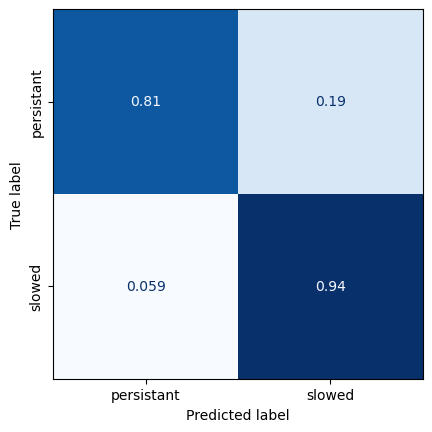

In [15]:
ConfusionMatrixDisplay.from_predictions(y_test,y_test_pred,
                                        normalize='true',
                                        colorbar=False,
                                        cmap='Blues')
plt.yticks(rotation=90, va='center')
#plt.savefig('images/synth_conf_matrix.png',dpi=300, bbox_inches="tight")

(array([0, 1]), [Text(0, 0, 'persistant'), Text(0, 1, 'slowed')])

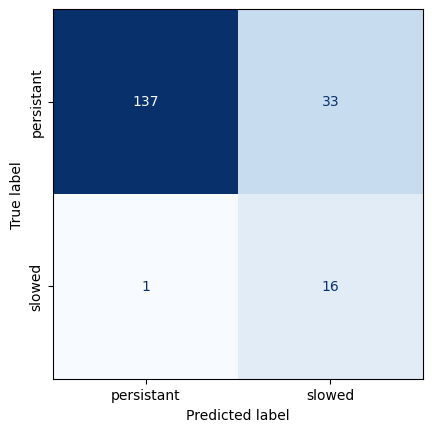

In [16]:
ConfusionMatrixDisplay.from_predictions(y_test,y_test_pred,
                                        colorbar=False,
                                        cmap='Blues')
plt.yticks(rotation=90, va='center')
#plt.savefig('images/synth_conf_matrix.png',dpi=300, bbox_inches="tight")

In [17]:
x_real = x.loc[realDrops.index]
y_real = y.loc[realDrops.index]
real_pred = estimator.predict(x_real)

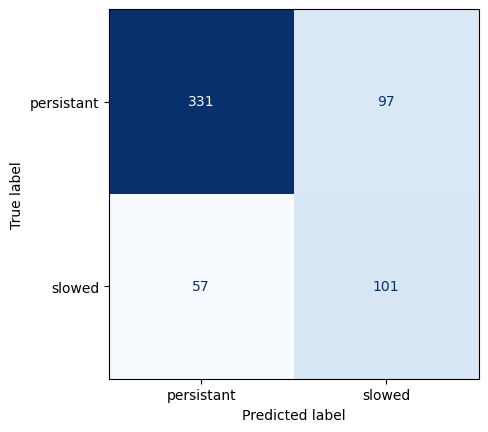

In [18]:
ConfusionMatrixDisplay.from_predictions(y_real,real_pred,
                                        colorbar=False,
                                        cmap='Blues')

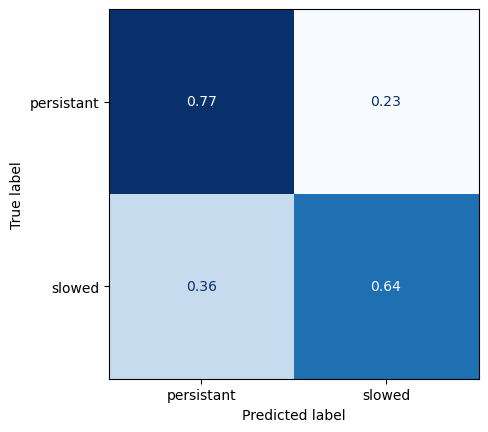

In [19]:
ConfusionMatrixDisplay.from_predictions(y_real,real_pred,
                                        normalize='true',
                                        colorbar=False,
                                        cmap='Blues')